# [Titanic - Machine learning from Disaster](https://www.kaggle.com/competitions/titanic/)

- [My notebook](https://www.kaggle.com/code/param302/titanic-survival-competition-8)

# Approach
1. Import libraries
2. Load data
2. Impute outliers with median (columns)
3. Filling null values with `median`(num) & `most_frequent`(cat)
3. Get best Mutual Information columns
4. Create new columns with them
5. Select useful features
6. Extract numerical and categorical columns
7. Make Pipeline
8. Do hyperparameter tuning with cross-validation (`XGBClassifier`)
9. Check MAE score
10. Select best parameters
11. Train model
12. Predict `Survived` on `test_data`
13. Submit predictions

## 1. Importing required libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif

## 2. Load data

In [3]:
data = pd.read_csv("../input/titanic/train.csv", index_col="PassengerId")
test_data = pd.read_csv("../input/titanic/test.csv", index_col="PassengerId")

data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3. Imputing outliers with their column's median value

<AxesSubplot:xlabel='Fare', ylabel='PassengerId'>

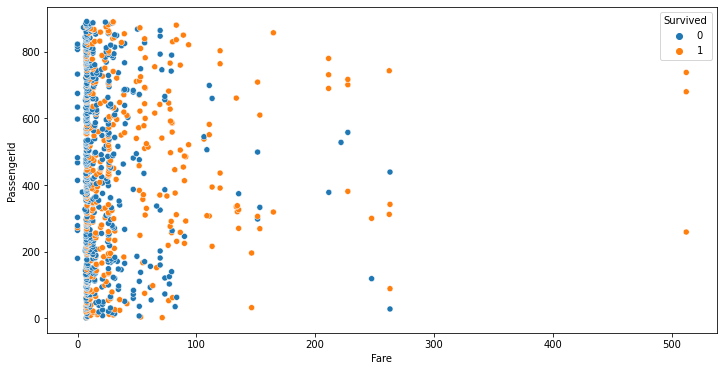

In [4]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=data["Fare"], y=data.index, hue="Survived", data=data)

In [5]:
outliers = data[data["Fare"]>200].index
outliers

Int64Index([ 28,  89, 119, 259, 300, 312, 342, 378, 381, 439, 528, 558, 680,
            690, 701, 717, 731, 738, 743, 780],
           dtype='int64', name='PassengerId')

In [6]:
data.loc[outliers, "Fare"] = data["Fare"].median()

<AxesSubplot:xlabel='Fare', ylabel='PassengerId'>

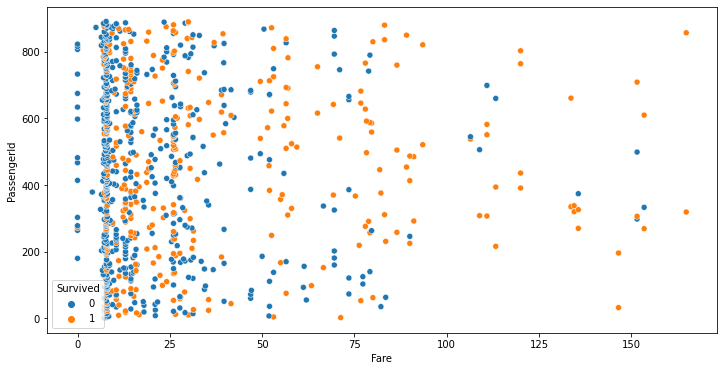

In [7]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=data["Fare"], y=data.index, hue="Survived", data=data)

## 4. Filling null values with `median`(num) & `most_frequent`(cat)

In [8]:
def impute_data(data, num_strategy="median", cat_strategy="most_frequent"):
    X = data.copy()
    index = X.index
    num_cols = X.select_dtypes(exclude="object").columns
    cat_cols = X.select_dtypes("object").columns    
    
    num_imputer = SimpleImputer(strategy=num_strategy)
    cat_imputer = SimpleImputer(strategy=cat_strategy)
    
    X[num_cols] = pd.DataFrame(num_imputer.fit_transform(X[num_cols]), index=index, columns=num_cols)
    X[cat_cols] = pd.DataFrame(cat_imputer.fit_transform(X[cat_cols]), index=index, columns=cat_cols)
    return X

In [9]:
X = data.copy()
Y = X.pop("Survived")
X = impute_data(X)
test_data = impute_data(test_data)

X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,B96 B98,S
2,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C
3,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,B96 B98,S
4,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
5,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,B96 B98,S


## 5. Getting best Mutual Information columns

In [10]:
def get_mi_score(X, y):
    # impute only if anything is missing, else use as it is
    X = impute_data(X) if X.isnull().sum().any() else X.copy()
    
    # Converting values of discrete features to numerical values
    for col in X.select_dtypes(["object"]):
        X[col] = X[col].factorize()[0]
    
    discrete_features = X.dtypes == int
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns).sort_values(ascending=False)
    return mi_scores

In [11]:
mi_scores = get_mi_score(X, Y)
mi_scores

Name        0.665912
Ticket      0.572496
Cabin       0.159859
Sex         0.150870
Fare        0.134668
Pclass      0.059235
SibSp       0.048427
Age         0.033732
Parch       0.027421
Embarked    0.014233
Name: MI Scores, dtype: float64

In [12]:
data[mi_scores.index]

,Name,Ticket,Cabin,Sex,Fare,Pclass,SibSp,Age,Parch,Embarked
PassengerId,,,,,,,,,,
1,"Braund, Mr. Owen Harris",A/5 21171,NaN,male,7.2500,3,1,22.0,0,S
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C85,female,71.2833,1,1,38.0,0,C
3,"Heikkinen, Miss. Laina",STON/O2. 3101282,NaN,female,7.9250,3,0,26.0,0,S
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,C123,female,53.1000,1,1,35.0,0,S
5,"Allen, Mr. William Henry",373450,NaN,male,8.0500,3,0,35.0,0,S
...,...,...,...,...,...,...,...,...,...,...
887,"Montvila, Rev. Juozas",211536,NaN,male,13.0000,2,0,27.0,0,S
888,"Graham, Miss. Margaret Edith",112053,B42,female,30.0000,1,0,19.0,0,S
889,"Johnston, Miss. Catherine Helen ""Carrie""",W./C. 6607,NaN,female,23.4500,3,1,NaN,2,S


## 6. Creating new columns

#### Creating 2 new columns `Tikcet_code`, `Ticket_number` from `Ticket` column

In [13]:
data["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [14]:
def split_tickets(tickets):
    raw_tickets = [i.split(" ") for i in tickets]
    for ticket in raw_tickets:
        if len(ticket) == 3:
            if ticket[1][0].isdigit():
                ticket[1:] = [ticket[1] + ticket[2]]
            else:    # if 2nd element is word 
                ticket[:2] = [ticket[0] + ticket[1]]

        if len(ticket) != 2:
            ticket[:-1] = ["missing"]
    
    # Getting mode of ticket code, 1st is "missing", using second
    common_ticket_codes = Counter([i[0] for i in raw_tickets]).most_common(2)
    mode_ticket_code = common_ticket_codes[1][0] if common_ticket_codes[0][0]=="missing" else common_ticket_codes[0][0]

    tickets_df = pd.DataFrame(raw_tickets, columns=["Ticket_code", "Ticket_number"], index=tickets.index)
    return tickets_df.replace({"missing": mode_ticket_code})

In [15]:
new_tickets_df = split_tickets(data["Ticket"])
new_tickets_df

,Ticket_code,Ticket_number
PassengerId,,
1,A/5,21171
2,PC,17599
3,STON/O2.,3101282
4,PC,113803
5,PC,373450
...,...,...
887,PC,211536
888,PC,112053
889,W./C.,6607


In [16]:
X = X.join(new_tickets_df)

In [17]:
X

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_code,Ticket_number
PassengerId,,,,,,,,,,,,
1,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,B96 B98,S,A/5,21171
2,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,PC,17599
3,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,B96 B98,S,STON/O2.,3101282
4,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,PC,113803
5,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,B96 B98,S,PC,373450
...,...,...,...,...,...,...,...,...,...,...,...,...
887,2.0,"Montvila, Rev. Juozas",male,27.0,0.0,0.0,211536,13.0000,B96 B98,S,PC,211536
888,1.0,"Graham, Miss. Margaret Edith",female,19.0,0.0,0.0,112053,30.0000,B42,S,PC,112053
889,3.0,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1.0,2.0,W./C. 6607,23.4500,B96 B98,S,W./C.,6607


#### Creating `Total_members` by counting total from `SibSp` and `Parch`

In [18]:
X["Total_members"] = X[["SibSp", "Parch"]].sum(axis=1)

In [19]:
X

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_code,Ticket_number,Total_members
PassengerId,,,,,,,,,,,,,
1,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,B96 B98,S,A/5,21171,1.0
2,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,PC,17599,1.0
3,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,B96 B98,S,STON/O2.,3101282,0.0
4,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,PC,113803,1.0
5,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,B96 B98,S,PC,373450,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2.0,"Montvila, Rev. Juozas",male,27.0,0.0,0.0,211536,13.0000,B96 B98,S,PC,211536,0.0
888,1.0,"Graham, Miss. Margaret Edith",female,19.0,0.0,0.0,112053,30.0000,B42,S,PC,112053,0.0
889,3.0,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1.0,2.0,W./C. 6607,23.4500,B96 B98,S,W./C.,6607,3.0


In [20]:
num_to_float_cols = ["Pclass", "Age", "SibSp", "Parch", "Total_members"]
X[num_to_float_cols] = X[num_to_float_cols].astype(int)

In [21]:
X

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_code,Ticket_number,Total_members
PassengerId,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,B96 B98,S,A/5,21171,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,PC,17599,1
3,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,B96 B98,S,STON/O2.,3101282,0
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,PC,113803,1
5,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,B96 B98,S,PC,373450,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,B96 B98,S,PC,211536,0
888,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S,PC,112053,0
889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28,1,2,W./C. 6607,23.4500,B96 B98,S,W./C.,6607,3


In [22]:
mi_scores

Name        0.665912
Ticket      0.572496
Cabin       0.159859
Sex         0.150870
Fare        0.134668
Pclass      0.059235
SibSp       0.048427
Age         0.033732
Parch       0.027421
Embarked    0.014233
Name: MI Scores, dtype: float64

#### Creating `PclassRatio` from count of each `Pclass`

In [23]:
def create_pclass_ratios(data):
    raw_pclassratio = pd.DataFrame(
        round(
              (data.groupby("Pclass")["Pclass"].agg("count") / data.Pclass.count()) * 100, 
              2)
        )
    raw_pclassratio.rename(columns={"Pclass": "PclassRatio"}, inplace=True)
    
    pclass_ratios = []
    for i in data["Pclass"]:
        pclass_ratios.append(raw_pclassratio.loc[i, "PclassRatio"])
    return pclass_ratios

In [24]:
X["PclassRatio"] = create_pclass_ratios(X)
X

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_code,Ticket_number,Total_members,PclassRatio
PassengerId,,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,B96 B98,S,A/5,21171,1,55.11
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,PC,17599,1,24.24
3,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,B96 B98,S,STON/O2.,3101282,0,55.11
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,PC,113803,1,24.24
5,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,B96 B98,S,PC,373450,0,55.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,B96 B98,S,PC,211536,0,20.65
888,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S,PC,112053,0,24.24
889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28,1,2,W./C. 6607,23.4500,B96 B98,S,W./C.,6607,3,55.11


#### Creating `PclassAvgFare` column based on `Fare` as per `Pclass`

In [25]:
def create_avg_pclass_fares(data):
    average_fares_pclass = pd.DataFrame(data.groupby("Pclass")["Fare"].mean())
    average_fares_pclass

    fares = []
    for i in data["Pclass"]:
        fares.append(average_fares_pclass.loc[i, "Fare"])
    return fares

In [26]:
X["PclassAvgFare"] = create_avg_pclass_fares(X)
X

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_code,Ticket_number,Total_members,PclassRatio,PclassAvgFare
PassengerId,,,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,B96 B98,S,A/5,21171,1,55.11,13.675550
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,PC,17599,1,24.24,59.631137
3,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,B96 B98,S,STON/O2.,3101282,0,55.11,13.675550
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,PC,113803,1,24.24,59.631137
5,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,B96 B98,S,PC,373450,0,55.11,13.675550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,B96 B98,S,PC,211536,0,20.65,20.662183
888,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S,PC,112053,0,24.24,59.631137
889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28,1,2,W./C. 6607,23.4500,B96 B98,S,W./C.,6607,3,55.11,13.675550


#### Creating `TotalCabins` by counting no. of cabins in each row

In [27]:
def create_total_cabins(data):
    index = data.index
    total_cabins = [len(i.split(" ")) for i in data["Cabin"]]
    return pd.Series(total_cabins, index=index, name="TotalCabins")

In [28]:
X["TotalCabins"] = create_total_cabins(X)
X

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_code,Ticket_number,Total_members,PclassRatio,PclassAvgFare,TotalCabins
PassengerId,,,,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,B96 B98,S,A/5,21171,1,55.11,13.675550,2
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,PC,17599,1,24.24,59.631137,1
3,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,B96 B98,S,STON/O2.,3101282,0,55.11,13.675550,2
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,PC,113803,1,24.24,59.631137,1
5,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,B96 B98,S,PC,373450,0,55.11,13.675550,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,B96 B98,S,PC,211536,0,20.65,20.662183,2
888,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S,PC,112053,0,24.24,59.631137,1
889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28,1,2,W./C. 6607,23.4500,B96 B98,S,W./C.,6607,3,55.11,13.675550,2


#### Creating `SexRatio` based on `Sex`

In [29]:
def create_sex_ratio(data):
    ratio = round((data.groupby("Sex")["Sex"].agg("count") / len(data)) * 100, 2)
    ratio_list = []
    for i in data["Sex"]:
        ratio_list.append(ratio.loc[i])
    return pd.DataFrame(ratio_list, index=data.index, columns=["SexRatio"])

In [30]:
X = X.join(create_sex_ratio(X))
X

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_code,Ticket_number,Total_members,PclassRatio,PclassAvgFare,TotalCabins,SexRatio
PassengerId,,,,,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,B96 B98,S,A/5,21171,1,55.11,13.675550,2,64.76
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,PC,17599,1,24.24,59.631137,1,35.24
3,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,B96 B98,S,STON/O2.,3101282,0,55.11,13.675550,2,35.24
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,PC,113803,1,24.24,59.631137,1,35.24
5,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,B96 B98,S,PC,373450,0,55.11,13.675550,2,64.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,B96 B98,S,PC,211536,0,20.65,20.662183,2,64.76
888,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S,PC,112053,0,24.24,59.631137,1,35.24
889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28,1,2,W./C. 6607,23.4500,B96 B98,S,W./C.,6607,3,55.11,13.675550,2,35.24


#### Creating `EmbarkedRatio` based on `Embarked location`

In [31]:
X["Embarked"].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [32]:
def create_embarkment_ratio(data):
    ratio = round((data.groupby("Embarked")["Embarked"].agg("count") / len(data)) * 100, 2)
    ratio_list = []
    for i in data["Embarked"]:
        ratio_list.append(ratio.loc[i])
    return pd.DataFrame(ratio_list, index=data.index, columns=["EmbarkedRatio"])

In [33]:
X = X.join(create_embarkment_ratio(X))
X

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_code,Ticket_number,Total_members,PclassRatio,PclassAvgFare,TotalCabins,SexRatio,EmbarkedRatio
PassengerId,,,,,,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,B96 B98,S,A/5,21171,1,55.11,13.675550,2,64.76,72.50
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,PC,17599,1,24.24,59.631137,1,35.24,18.86
3,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,B96 B98,S,STON/O2.,3101282,0,55.11,13.675550,2,35.24,72.50
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,PC,113803,1,24.24,59.631137,1,35.24,72.50
5,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,B96 B98,S,PC,373450,0,55.11,13.675550,2,64.76,72.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,B96 B98,S,PC,211536,0,20.65,20.662183,2,64.76,72.50
888,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S,PC,112053,0,24.24,59.631137,1,35.24,72.50
889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28,1,2,W./C. 6607,23.4500,B96 B98,S,W./C.,6607,3,55.11,13.675550,2,35.24,72.50


### checking MI score again on new columns

In [34]:
mi_scores = get_mi_score(X, Y)
mi_scores

Name             0.665912
Ticket           0.572496
Ticket_number    0.570940
Cabin            0.159859
Sex              0.150870
SexRatio         0.135355
Fare             0.127974
PclassRatio      0.076914
Age              0.066706
PclassAvgFare    0.063309
Pclass           0.058107
TotalCabins      0.048460
Total_members    0.047781
Ticket_code      0.039498
SibSp            0.023197
Parch            0.016366
Embarked         0.014233
EmbarkedRatio    0.011125
Name: MI Scores, dtype: float64

#### Creating same features for our `test_data`

In [35]:
test_data = test_data.join(split_tickets(test_data["Ticket"]))

In [36]:
test_data["PclassRatio"] = create_pclass_ratios(test_data)
test_data["PclassAvgFare"] = create_avg_pclass_fares(test_data)

In [37]:
test_data["Total_members"] = test_data[["SibSp", "Parch"]].sum(axis=1)

In [38]:
test_data["TotalCabins"] = create_total_cabins(test_data)

In [39]:
test_data = test_data.join(create_sex_ratio(test_data))

In [40]:
test_data = test_data.join(create_embarkment_ratio(test_data))

In [41]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_code,Ticket_number,PclassRatio,PclassAvgFare,Total_members,TotalCabins,SexRatio,EmbarkedRatio
PassengerId,,,,,,,,,,,,,,,,,,
892,3.0,"Kelly, Mr. James",male,34.5,0.0,0.0,330911,7.8292,B57 B59 B63 B66,Q,PC,330911,52.15,12.468827,0.0,4,63.64,11.00
893,3.0,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1.0,0.0,363272,7.0000,B57 B59 B63 B66,S,PC,363272,52.15,12.468827,1.0,4,36.36,64.59
894,2.0,"Myles, Mr. Thomas Francis",male,62.0,0.0,0.0,240276,9.6875,B57 B59 B63 B66,Q,PC,240276,22.25,22.202104,0.0,4,63.64,11.00
895,3.0,"Wirz, Mr. Albert",male,27.0,0.0,0.0,315154,8.6625,B57 B59 B63 B66,S,PC,315154,52.15,12.468827,0.0,4,63.64,64.59
896,3.0,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1.0,1.0,3101298,12.2875,B57 B59 B63 B66,S,PC,3101298,52.15,12.468827,2.0,4,36.36,64.59


## 7. Selecting useful features

In [42]:
useful_features = mi_scores.index
X = X[useful_features]
test_data = test_data[useful_features]
useful_features

Index(['Name', 'Ticket', 'Ticket_number', 'Cabin', 'Sex', 'SexRatio', 'Fare',
       'PclassRatio', 'Age', 'PclassAvgFare', 'Pclass', 'TotalCabins',
       'Total_members', 'Ticket_code', 'SibSp', 'Parch', 'Embarked',
       'EmbarkedRatio'],
      dtype='object')

## 8. Extracting numerical and categorical columns

In [43]:
num_cols = X.select_dtypes(exclude="object").columns
cat_cols = X.select_dtypes("object").columns
num_cols, cat_cols

(Index(['SexRatio', 'Fare', 'PclassRatio', 'Age', 'PclassAvgFare', 'Pclass',
        'TotalCabins', 'Total_members', 'SibSp', 'Parch', 'EmbarkedRatio'],
       dtype='object'),
 Index(['Name', 'Ticket', 'Ticket_number', 'Cabin', 'Sex', 'Ticket_code',
        'Embarked'],
       dtype='object'))

## 9. Making Pipeline

In [44]:
class CreatePipeline:
    """Create Pipeline
    methods:
        pipeline: Create Final Pipeline
        
        create_model: Create the provided model
        
        numerical_transformer: Transform numerical cols
        
        categorical_transformer: Transform categorical cols \
        OneHotEncoding / OrdinalEncoding
        
        data_preprocessor: Preprocess the data using ColumnTransformer     
        """
    
    def pipeline(self, *, preprocessor, model, verbose=False):
        """Creates pipeline
        params:
            preprocessor
            model
        """
        steps = [("preprocessor", preprocessor),
                 ("model", model)]
        return Pipeline(steps=steps, verbose=verbose)
    
    
    def numerical_transformer(self, *, strategy="mean", **params):
        """Transform numerical columns using `SimpleImputer`.
        params:
            strategy: "mean" | "median" | "most_frequent" | "constant"
            **params: extra keyword args for SimpleImputer"""
        
        transformer = SimpleImputer(strategy=strategy, **params)
        return transformer

    
    def categorical_transformer(self, *, 
                                imp_strategy="most_frequent", 
                                encoder_type="Ordinal", 
                                imp_params={}, encoder_params={}):
        """Transform categorical columns by making Pipeline
        `SimpleImputer` | `OneHotEncoder` | `OrdinalEncoder`.
        args:
            imp_strategy: strategy for imputer values can be
                "most_frequent" | "constant"
            encoder_type: encoder type,
                "Ordinal" | "OneHot"
        kwargs:
            imp_params: keyword args for `SimpleImputer`.
            encoder_params: keyword args for encoder.`
        """
        if not encoder_type in ("Ordinal", "OneHot"):
            raise ValueError(f"Inappropriate value for encoder_type passed: {encoder_type}\
            Takes one of 'Ordinal' | 'OneHot'.")
        
        encoder = OrdinalEncoder if encoder_type=="Ordinal" else OneHotEncoder
        transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy=imp_strategy, **imp_params)),
            (encoder_type, encoder(**encoder_params))
        ])
        return transformer
    
    
    def data_preprocessor(self, *, transformers):
        """Preprocess the data using `ColumnTransformer`.
        Pass extact list of transformers
        to be passed in `ColumnTransformer`.
        each tuple consist of: (transformer_name,
                                transformer,
                                list_of_columns)."""
        preprocessor = ColumnTransformer(transformers=transformers)
        return preprocessor
    
    
    def create_model(self, *, model, random_state=0, n_estimators=1000, **kwargs):
        """Creates the model.
        **kwargs: keyword args for model."""
        my_model = model(random_state=random_state, n_estimators=n_estimators, **kwargs)
        return my_model

In [45]:
cp = CreatePipeline()
num_transformer = cp.numerical_transformer(strategy="median")
cat_transformer = cp.categorical_transformer(encoder_type="OneHot", encoder_params={"handle_unknown": "ignore"})
preprocessor = cp.data_preprocessor(
                    transformers=[("num", num_transformer, num_cols),
                                  ("cat", cat_transformer, cat_cols)
                                 ])

## 10. Doing hyperparameter tuning with cross-validation (`XGBClassifier`)

In [46]:
n_estimators = [500, 750, 1000]
max_depths = [5, 10]
learning_rate = [0.05, 0.1]
maes = {}
i = 0
for n in n_estimators:
    for md in max_depths:
        for rate in learning_rate:
            i += 1
            model = cp.create_model(model=XGBClassifier, n_estimators=n, max_depth=md, learning_rate=rate)
            pipeline = cp.pipeline(preprocessor=preprocessor, model=model)
            scores = -1 * cross_val_score(pipeline, X, Y, cv=10, verbose=True,
                                    scoring="neg_mean_absolute_error")
            mae = scores.mean()
            maes[i] = [n, md, rate, mae]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   35.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   35.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

## 11. Checking MAE scores

In [47]:
for i in maes:
    n, md, rate, mae = maes[i]
    print(f"{i}.\tN_estimators: {n}\tmax_depth: {md}\tlearning_rate: {rate}\tMAE: {mae}")

1.	N_estimators: 500	max_depth: 5	learning_rate: 0.05	MAE: 0.17726591760299623
2.	N_estimators: 500	max_depth: 5	learning_rate: 0.1	MAE: 0.18176029962546814
3.	N_estimators: 500	max_depth: 10	learning_rate: 0.05	MAE: 0.18625468164794007
4.	N_estimators: 500	max_depth: 10	learning_rate: 0.1	MAE: 0.18622971285892634
5.	N_estimators: 750	max_depth: 5	learning_rate: 0.05	MAE: 0.17390761548064917
6.	N_estimators: 750	max_depth: 5	learning_rate: 0.1	MAE: 0.18400749063670413
7.	N_estimators: 750	max_depth: 10	learning_rate: 0.05	MAE: 0.19072409488139824
8.	N_estimators: 750	max_depth: 10	learning_rate: 0.1	MAE: 0.1839825218476904
9.	N_estimators: 1000	max_depth: 5	learning_rate: 0.05	MAE: 0.17840199750312108
10.	N_estimators: 1000	max_depth: 5	learning_rate: 0.1	MAE: 0.18400749063670413
11.	N_estimators: 1000	max_depth: 10	learning_rate: 0.05	MAE: 0.19297128589263418
12.	N_estimators: 1000	max_depth: 10	learning_rate: 0.1	MAE: 0.18510611735330837


In [48]:
min(maes, key=lambda x: maes[x][3])

5

## 12. Selecting best parameters
#### `n_estimators: 750`
#### `learning_rate: 0.05`
#### `max_depth: 5`
#### `MAE: 0.17390761548064917`

In [49]:
best_n_estimators = 750
best_max_depth = 5
best_rate = 0.05

## 13. Training model on best parameters

In [50]:
model = cp.create_model(model=XGBClassifier, n_estimators=best_n_estimators, learning_rate=best_rate, max_depth=best_max_depth)
pipeline = cp.pipeline(preprocessor=preprocessor, model=model)
pipeline.fit(X, Y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['SexRatio', 'Fare', 'PclassRatio', 'Age', 'PclassAvgFare', 'Pclass',
       'TotalCabins', 'Total_members', 'SibSp', 'Parch', 'EmbarkedRatio'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OneHot',
                                                                   OneHotEncod...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_r

## 14. Predicting `Survived` on `test_data`

In [51]:
test_preds = pipeline.predict(test_data)
test_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,

## 15. Submitting predictions

In [52]:
output = pd.DataFrame({"PassengerId": test_data.index, "Survived": test_preds})
output.to_csv("./data/submission_8.csv", index=False)